# Holt-Winters Methods
지난 시간에 배웠던 **Exponentially Weighted Moving Averages**(EWMA)는 *Simple Exponential Smoothing*를 적용한 모델이였다. 더불어 이는 단 하나 smoothing factor인 $\alpha$만을 이용하였기 때문에 trend와 seasonality를 반영하지 못한다는 단점이 있었다.  
이번 시간에는 우리는 Holt-Winters Methods의 <em>Double</em> 그리고 <em>Triple Exponential Smoothing</em>에 대해서 공부할 것이다.

<br>

Holt's Method라고 불리는 **Double Exponential Smoothing**은 새로운 smoothing factor인 $\beta$가 존재하며 이는 trend를 설명한다.
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

이 모델은 아직 계절적 변동을 반영하지 않았기 때문에 예측 모형은 가장 최근의 데이터 지점에서 확장된 직선이다.

<br>

Holt-Winters Method라고 불리는 **Triple Exponential Smoothing**은 sessonality를 반영하는 smoothing factor인 $\gamma$가 존재한다.
\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

$L$은 사이클의 단위이며, 우리가 앞으로 보게 될 data는 monthly data이기 때문에 패턴이 일정한 월로 이루어진 각각의 년수이기 때문에 우리는 $L=12$로 사용할 것이다.  
일반적으로 $\alpha$, $\beta$, $\gamma$(1에 가까운 값)이 클수록 최근 데이터에 더 많은 강조점을 둔다.

### load dataset
- 우리가 사용하게 될 dataset은 International Airline Passengers dataset이다.
- 이는 1949년 1월부터 1960년 12월까지 월별 총 승객수를 나타낸 자료다.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../Data/airline_passengers.csv',
                 index_col='Month', 
                 parse_dates=True)

df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [2]:
print(df.index)

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


### Setting a DatatimeIndex Freaquency
위에서 나타난 DatatimeIndex의 frequency는 None으로 아직 지정되어 있지 않음을 알 수 있다. Holt-Winter smoothing을 사용하기 위해서는 statsmodel은 frequency에 대해서 지정해줘야 한다.(그것이 daily든 monthly이든 무엇이든지 간에)  
우리의 관측치가 매달 1일에 시작하기 때문에 우리는 MS를 이용할 것이다.     
다른 time series offset aliases에 대해선 <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>이 곳</a>을 참고하길 바란다.

In [3]:
df.index.freq = 'MS'
print(df.index)

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')


In [4]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Simple Exponential Smoothing

statmodels은 Holt-Winters 함수 중의 하나인 `SimpleExpSmoothing`을 제공합니다.  
이는 판다스의 `ewm`과 같은 계산으로써 가중 이동 평균치를 구합니다.<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [3]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA-12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()
df.head()

,Thousands of Passengers,EWMA-12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861


In [4]:
model = SimpleExpSmoothing(df['Thousands of Passengers'])
fitted_model = model.fit(smoothing_level=alpha, optimized=False)
df['SES-12'] = fitted_model.fittedvalues.shift(-1)   # optimized=False로 할 경우 결괏값이 하나씩 밀리는 현상이 있는데 이를 방지하기 위해서 shift를 지정

df.head()

,Thousands of Passengers,EWMA-12,SES-12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


## Double Exponential Smoothing
Simple Exponential Smoothing은 smoothing factor로 $\alpha$만을 받는 반면에, Double Exponential Smoothing은 trend의 변화를 반영하는 두번째 smoothing factor, $\beta$가 추가된다.  
$\alpha$와 비슷하게 $\beta$ 역시 0과 1사이에 존재한다($0<\beta≤1$). Simple Exponential Smoothing은 최근의 계산만이 작용한다는 반면에 Double Exponential Smoothing은 미래의 증가나 감소를 예상할 수 있다는 점이다.

trend에는 다른 타입의 변화로 나타낼 수 있다.  
만약 time series가 직선으로 기울어진 추세를 보이면 **additive** adjustment을 사용할 수 있고  
그게 아니라 지수형태의 변화를 보이면 **multiplicative** adjustment를 사용할 수 있다.  
additive adjustment과 multiplicative adjustment 모두 미래로 가며 증감이 없어지는 추세에서는 값을 과장하는 경향이 있어 이를 위해 감쇠가 필요할 때가 있다.

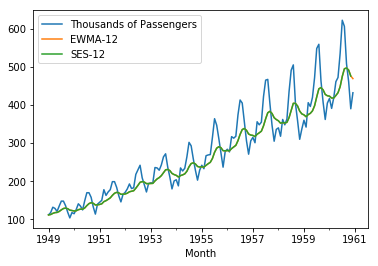

In [5]:
df.plot();

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA-12,SES12,DES_add_12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.336459
1949-02-01,118,112.923077,112.923077,120.336459
1949-03-01,132,115.857988,115.857988,134.336459
1949-04-01,129,117.879836,117.879836,131.336459
1949-05-01,121,118.359861,118.359861,123.336459


In [17]:
df.columns

Index(['Thousands of Passengers', 'EWMA-12', 'SES12', 'DES_add_12'], dtype='object')

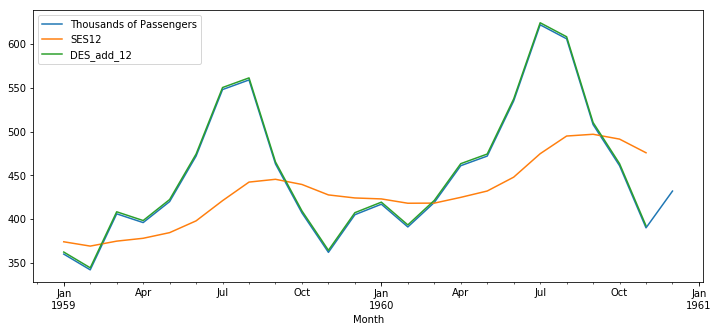

In [22]:
# 마지막 2년 동안만의 데이터만 살펴봄
df[['Thousands of Passengers', 'SES12', 'DES_add_12']].iloc[-24:].plot(figsize=(12, 5)); # 단순 지수 평활법 보다 이중 지수 평활법이 더 잘 설명하고 있음

In [23]:
# trend adjustment를 서로 비교하기 위해 trend='mul' 또한 살펴본다.
df['DES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA-12,SES12,DES_add_12,DES_mul_12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.336459,112.049247
1949-02-01,118,112.923077,112.923077,120.336459,118.051885
1949-03-01,132,115.857988,115.857988,134.336459,132.058041
1949-04-01,129,117.879836,117.879836,131.336459,129.056722
1949-05-01,121,118.359861,118.359861,123.336459,121.053204


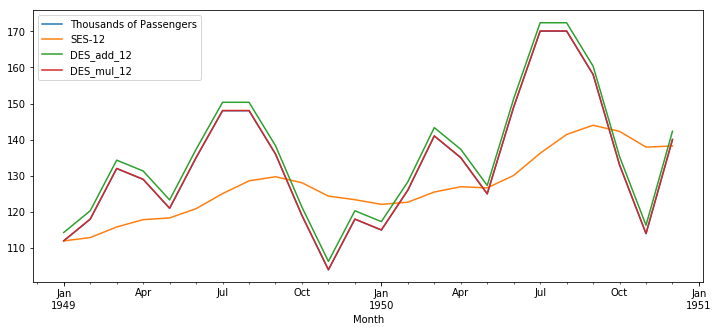

In [10]:
# 마지막 2년동안의 경우 두 모델이 거의 동일하지만
# 처음 2년동안의 데이터의 경우 곱셈 모델이 덧셈 모델보다 더 높은 성능을 보임
df[['Thousands of Passengers', 'SES-12', 'DES_add_12', 'DES_mul_12']].iloc[:24].plot(figsize=(12, 5));

## Triple Exponential Smoothing

Triple Exponential Smoothing은 데이터의 trend, seasonality 모두를 반영한다.

In [24]:
df['TES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'],
                                        trend='mul', 
                                        seasonal='mul',           # 삼중 지수 평활법에서는 seasonal에 대한 adjustment도 필요함
                                        seasonal_periods=12).fit().fittedvalues # shift가 필요없음(seasonal_periods라는 추가적인 인자 때문)
df.head()

,Thousands of Passengers,EWMA-12,SES12,DES_add_12,DES_mul_12,TES_mul_12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.336459,112.049247,111.583338
1949-02-01,118,112.923077,112.923077,120.336459,118.051885,118.835364
1949-03-01,132,115.857988,115.857988,134.336459,132.058041,133.352623
1949-04-01,129,117.879836,117.879836,131.336459,129.056722,127.901871
1949-05-01,121,118.359861,118.359861,123.336459,121.053204,120.989261


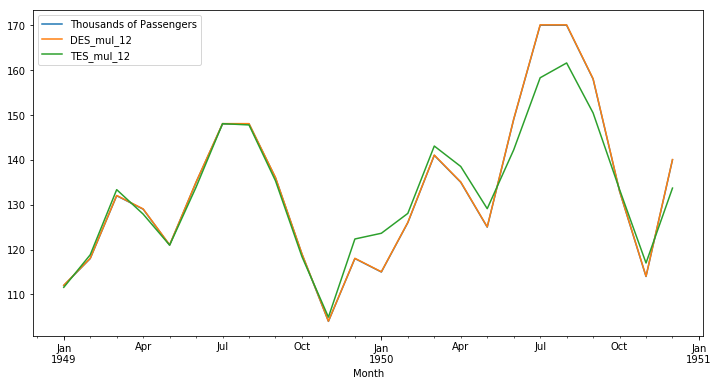

In [28]:
# 첫 2년 데이터의 예상치를 보면 이중 평활 지수가 더 정확한 것으로 보인다.
# 하지만 예측할 때에는 계절적 변동까지 예측할 수 있는 능력이 예측 정확성을 상당히 올려줌
df[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[:24].plot(figsize=(12, 6));

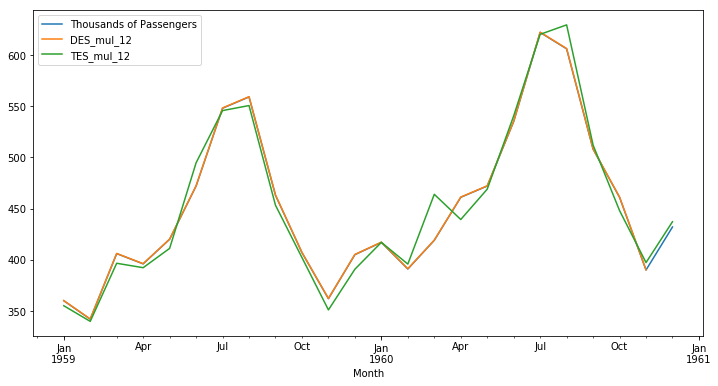

In [26]:
df[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[-24:].plot(figsize=(12, 6));